In [2]:
#sri rama jayam
!pip install gymnasium
!pip install flappy-bird-gymnasium
!pip install matplotlib
!pip install pyyaml

In [3]:
import gymnasium
import flappy_bird_gymnasium
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import yaml
import time

In [4]:
!pip install flappy-bird-gymnasium

In [5]:
# Quick environment test to see if it works
env = gymnasium.make("FlappyBird-v0", render_mode='human', use_lidar=True)
obs, _ = env.reset()
print("Observation shape:", obs.shape)

for _ in range(100):  # Run for 100 steps or until game over
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        break

env.close()

/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Observation shape: (180,)


In [6]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

    def to_device(self, device):
        return self.to(device)

In [7]:
class ReplayMemory:
    def __init__(self, maxlen, seed=None):
        self.memory = deque([], maxlen=maxlen)

        if seed is not None:
            random.seed(seed)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [8]:
%%writefile hyperparameters.yml
flappybird:
  env_id: FlappyBird-v0
  replay_memory_size: 100000
  mini_batch_size: 64
  epsilon_init: 1.0
  epsilon_decay: 0.995
  epsilon_min: 0.05
  discount_factor: 0.99
  learning_rate: 0.0001
  network_sync_rate: 1000
  training_episodes: 5000

Writing hyperparameters.yml


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

class Agent:
    def __init__(self, hyperparameter_set):
        with open("hyperparameters.yml", 'r') as file:
            all_hyperparameter_sets = yaml.safe_load(file)
            hyperparameters = all_hyperparameter_sets[hyperparameter_set]

            # Load hyperparameters
            self.env_id = hyperparameters['env_id']
            self.replay_memory_size = hyperparameters['replay_memory_size']
            self.mini_batch_size = hyperparameters['mini_batch_size']
            self.epsilon_init = hyperparameters['epsilon_init']
            self.epsilon_decay = hyperparameters['epsilon_decay']
            self.epsilon_min = hyperparameters['epsilon_min']
            self.discount_factor = hyperparameters['discount_factor']
            self.learning_rate = hyperparameters['learning_rate']
            self.network_sync_rate = hyperparameters['network_sync_rate']
            self.training_episodes = hyperparameters['training_episodes']

            self.memory = ReplayMemory(self.replay_memory_size)

    def optimize(self, mini_batch, policy_dqn, target_dqn, optimizer):
        states, actions, new_states, rewards, terminated = zip(*mini_batch)

        # Convert to tensors
        states = torch.stack(states)
        actions = torch.tensor(actions, dtype=torch.long, device=device)
        new_states = torch.stack(new_states)
        rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
        terminated = torch.tensor(terminated, dtype=torch.bool, device=device)

        # Calculate current Q values
        current_q_values = policy_dqn(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Calculate next Q values (with target network)
        next_q_values = torch.zeros(len(mini_batch), device=device)
        with torch.no_grad():
            next_q_values[~terminated] = target_dqn(new_states[~terminated]).max(1)[0]

        # Calculate target Q values
        target_q_values = rewards + (self.discount_factor * next_q_values)

        # Calculate loss
        loss = F.mse_loss(current_q_values, target_q_values)

        # Optimize the policy network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    def train(self, render_training=False, render_interval=100):
        # Create environment
        env = gymnasium.make("FlappyBird-v0", render_mode="human" if render_training else None, use_lidar=True)

        # Get state and action dimensions
        state, _ = env.reset()
        num_states = len(state)
        num_actions = env.action_space.n

        print(f"State dimension: {num_states}, Action dimension: {num_actions}")

        # Initialize networks
        policy_dqn = DQN(num_states, num_actions).to(device)
        target_dqn = DQN(num_states, num_actions).to(device)
        target_dqn.load_state_dict(policy_dqn.state_dict())
        target_dqn.eval()  # Set target network to evaluation mode

        # Initialize optimizer
        optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate)

        # Training variables
        rewards_per_episode = []
        epsilon = self.epsilon_init
        epsilon_history = []
        losses = []
        step_count = 0
        best_reward = -float('inf')

        for episode in range(self.training_episodes):
            # Reset environment
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device)

            # Render only at specific intervals if not rendering all training
            if not render_training and episode % render_interval == 0:
                render_env = gymnasium.make("FlappyBird-v0", render_mode="human", use_lidar=True)
                render_state, _ = render_env.reset()
                render_terminated = False

                while not render_terminated:
                    with torch.no_grad():
                        render_tensor = torch.tensor(render_state, dtype=torch.float32, device=device)
                        render_action = policy_dqn(render_tensor.unsqueeze(0)).argmax().item()

                    render_state, _, render_terminated, render_truncated, _ = render_env.step(render_action)
                    render_terminated = render_terminated or render_truncated
                    time.sleep(0.01)  # Slow down rendering for visibility

                render_env.close()

            terminated = False
            truncated = False
            episode_reward = 0
            episode_loss = 0
            step_in_episode = 0

            while not (terminated or truncated):
                # Select action with epsilon-greedy policy
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        action = policy_dqn(state.unsqueeze(0)).argmax().item()

                # Execute action
                new_state, reward, terminated, truncated, _ = env.step(action)
                new_state = torch.tensor(new_state, dtype=torch.float32, device=device)

                # Store transition in replay memory
                self.memory.append((state, action, new_state, reward, terminated))

                # Update state and counters
                state = new_state
                episode_reward += reward
                step_count += 1
                step_in_episode += 1

                # Train the network if enough samples are available
                if len(self.memory) >= self.mini_batch_size:
                    mini_batch = self.memory.sample(self.mini_batch_size)
                    loss = self.optimize(mini_batch, policy_dqn, target_dqn, optimizer)
                    episode_loss += loss

                # Update target network periodically
                if step_count % self.network_sync_rate == 0:
                    target_dqn.load_state_dict(policy_dqn.state_dict())

            # Update epsilon (exploration rate)
            epsilon = max(self.epsilon_min, epsilon * self.epsilon_decay)

            # Store episode statistics
            rewards_per_episode.append(episode_reward)
            epsilon_history.append(epsilon)
            avg_loss = episode_loss / step_in_episode if step_in_episode > 0 else 0
            losses.append(avg_loss)

            # Save best model
            if episode_reward > best_reward:
                best_reward = episode_reward
                torch.save(policy_dqn.state_dict(), 'best_flappy_model.pth')

            # Print progress
            if episode % 10 == 0:
                avg_reward = np.mean(rewards_per_episode[-10:]) if len(rewards_per_episode) >= 10 else np.mean(rewards_per_episode)
                print(f"Episode {episode}/{self.training_episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.4f}, Avg Loss: {avg_loss:.6f}")

        env.close()

        # Plot training progress
        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.plot(rewards_per_episode)
        plt.title('Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')

        plt.subplot(3, 1, 2)
        plt.plot(epsilon_history)
        plt.title('Epsilon Decay')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')

        plt.subplot(3, 1, 3)
        plt.plot(losses)
        plt.title('Average Loss per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Loss')

        plt.tight_layout()
        plt.savefig('training_progress.png')
        plt.show()

        return policy_dqn, rewards_per_episode
    def evaluate(self, model_path=None, num_episodes=10):
        # Load model if path is provided
        if model_path:
            env = gymnasium.make("FlappyBird-v0", render_mode="human", use_lidar=True)
            num_states = env.observation_space.shape[0]
            num_actions = env.action_space.n

            policy_dqn = DQN(num_states, num_actions).to(device)
            policy_dqn.load_state_dict(torch.load(model_path))
            policy_dqn.eval()
        else:
            # Create environment
            env = gymnasium.make("FlappyBird-v0", render_mode="human", use_lidar=True)

            # Get state and action dimensions
            state, _ = env.reset()
            num_states = len(state)
            num_actions = env.action_space.n

            # Initialize networks
            policy_dqn = DQN(num_states, num_actions).to(device)
            policy_dqn.load_state_dict(torch.load('best_flappy_model.pth'))
            policy_dqn.eval()

        # Evaluation
        rewards = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device=device)

            terminated = False
            truncated = False
            episode_reward = 0

            while not (terminated or truncated):
                # Select action
                with torch.no_grad():
                    action = policy_dqn(state.unsqueeze(0)).argmax().item()

                # Execute action
                state, reward, terminated, truncated, _ = env.step(action)
                state = torch.tensor(state, dtype=torch.float32, device=device)

                episode_reward += reward
                time.sleep(0.01)  # Slow down rendering for visibility

            rewards.append(episode_reward)
            print(f"Episode {episode+1}/{num_episodes}, Reward: {episode_reward}")

        env.close()
        avg_reward = np.mean(rewards)
        print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")

        return avg_reward

Using device: cuda


In [13]:
# Quick environment test to see if it works
env = gymnasium.make("FlappyBird-v0", render_mode='human', use_lidar=True)
obs, _ = env.reset()
print("Observation shape:", obs.shape)

for _ in range(100):  # Run for 100 steps or until game over
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        break

env.close()

Observation shape: (180,)


State dimension: 180, Action dimension: 2
Episode 0/5000, Avg Reward: -7.50, Epsilon: 0.9950, Avg Loss: 0.000000
Episode 10/5000, Avg Reward: -7.50, Epsilon: 0.9464, Avg Loss: 0.008947
Episode 20/5000, Avg Reward: -7.20, Epsilon: 0.9001, Avg Loss: 0.026439
Episode 30/5000, Avg Reward: -7.26, Epsilon: 0.8561, Avg Loss: 0.006399
Episode 40/5000, Avg Reward: -7.80, Epsilon: 0.8142, Avg Loss: 0.020932
Episode 50/5000, Avg Reward: -7.62, Epsilon: 0.7744, Avg Loss: 0.005365
Episode 60/5000, Avg Reward: -6.54, Epsilon: 0.7366, Avg Loss: 0.018207
Episode 70/5000, Avg Reward: -7.38, Epsilon: 0.7005, Avg Loss: 0.006200
Episode 80/5000, Avg Reward: -6.78, Epsilon: 0.6663, Avg Loss: 0.019744
Episode 90/5000, Avg Reward: -6.18, Epsilon: 0.6337, Avg Loss: 0.006554
Episode 100/5000, Avg Reward: -7.02, Epsilon: 0.6027, Avg Loss: 0.016770
Episode 110/5000, Avg Reward: -6.30, Epsilon: 0.5733, Avg Loss: 0.008670
Episode 120/5000, Avg Reward: -6.96, Epsilon: 0.5452, Avg Loss: 0.020660
Episode 130/5000, Av

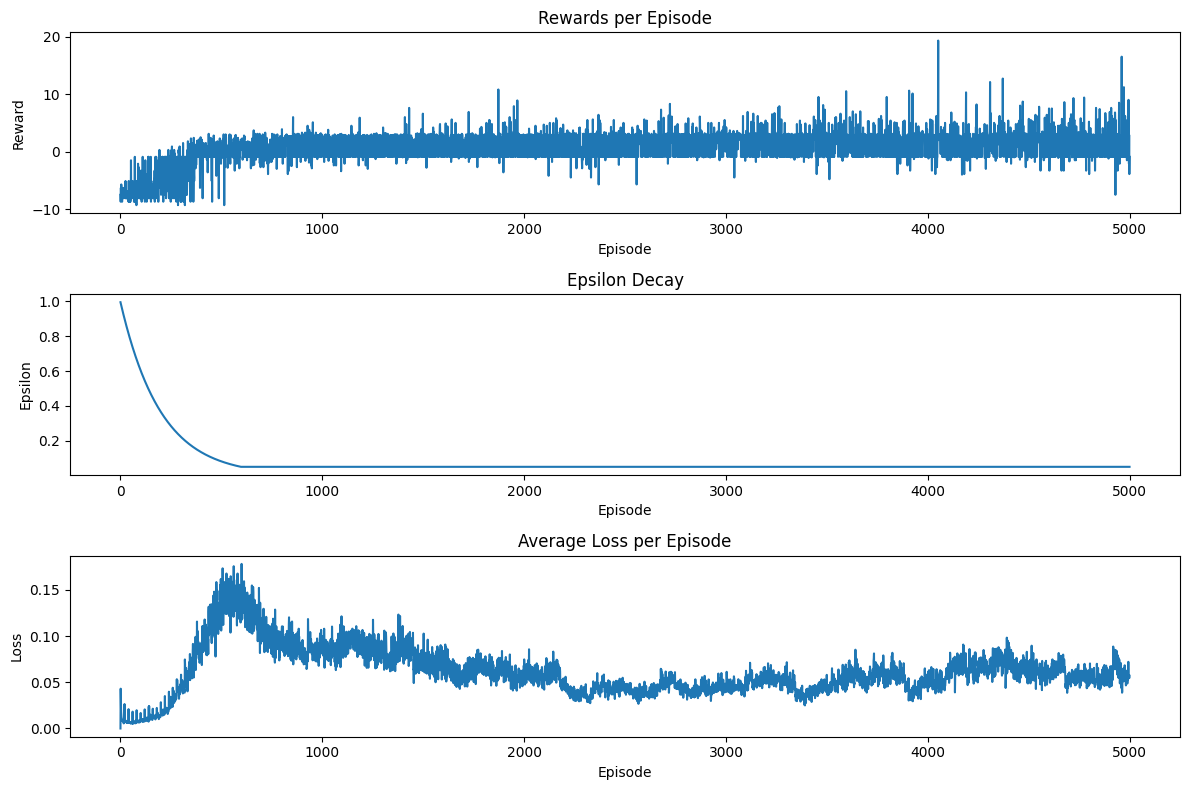

In [14]:
agent = Agent("flappybird")

# Set render_training to True if you want to watch all episodes during training,
# or use render_interval to occasionally watch the agent's progress
policy_dqn, rewards = agent.train(render_training=False, render_interval=50)

# Save the final model
torch.save(policy_dqn.state_dict(), 'final_flappy_model.pth')


In [15]:
# Function to play the game using a trained model
def play_flappy_bird(model_path='best_flappy_model.pth', num_games=3):
    # Create environment
    env = gymnasium.make("FlappyBird-v0", render_mode="human", use_lidar=True)

    # Load model
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.n

    policy_dqn = DQN(num_states, num_actions).to(device)
    policy_dqn.load_state_dict(torch.load(model_path))
    policy_dqn.eval()

    for game in range(num_games):
        state, _ = env.reset()
        done = False
        score = 0

        print(f"Game {game+1}/{num_games}")

        while not done:
            # Convert state to tensor
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

            # Get action from policy
            with torch.no_grad():
                action = policy_dqn(state_tensor).argmax().item()

            # Take action
            state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            score += reward

            # Add a small delay to make it easier to watch
            time.sleep(0.01)

        print(f"Game {game+1} score: {score}")

    env.close()

# Run the game with the best model
play_flappy_bird(model_path='best_flappy_model.pth', num_games=3)

Game 1/3
Game 1 score: 10.69999999999997
Game 2/3
Game 2 score: 11.19999999999997
Game 3/3
Game 3 score: 7.799999999999985
